This notebook loads Yelp data related to Toronto restaurants only.  This will eventually replace the data model in the original data load module.

In [273]:
from neo4j.v1 import GraphDatabase, basic_auth
import csv
import json
import os
import pandas as pd
import matplotlib.pyplot as plt

In [274]:
uri  = os.getenv('NEO4J_URI',  'bolt://localhost:7687')
user = os.getenv('NEO4J_USER', 'neo4j')
pwd  = os.getenv('NEO4J_PWD',  'neo4j')

driver = GraphDatabase.driver(uri, auth=basic_auth(user, pwd))

In [281]:
# contains raw JSON files
data_dir   = '/Users/gtenorio/neo4j/neo4j/yelp_data'

# contains subsetted CSV files to be loaded into Neo4j
import_dir = '/var/lib/neo4j/import/'

In [276]:
# Helper functions

# Specify CSV parameters through custom dialect
csv.register_dialect('custom', escapechar='\\', quotechar='"', quoting=csv.QUOTE_ALL)


def identity(x): 
    return x


def select(keys, d):
    return {key: value for (key, value) in d.items() if key in set(keys)}


# Converts the given value to a CSV formatted string
def toCSV(value):
    # Represent a list of items as a semicolon delimited string
    if type(value) == list:
        return ';'.join(value)

    # Surround fields with double quotes and handle escape characters
    if type(value) == str:
        return value.replace('"', '').replace('\\', '')

    return value


# Converts a dict to a list of CSV formatted strings, optionally restricting
# converted fields by passing in an ordered list of fields
def dictToCSV(obj, fields=None):
    fields = fields if fields is not None else obj.keys()
    return [toCSV(obj[k]) for k in fields]


# Takes a JSON file and writes it as a CSV file
def jsonToCSVFile(json_file, csv_file=None, transform=identity):

    root, ext = os.path.splitext(json_file)
    csv_file = csv_file if csv_file else root + '.csv'

    with open(json_file, 'r') as jsonFile, \
         open(csv_file, 'w') as csvFile:

        objs = transform(map(json.loads, jsonFile))
        first = next(objs)
        fields = first.keys()

        writer = csv.writer(csvFile, dialect='custom')
        writer.writerow(fields)         # write header

        writer.writerow(dictToCSV(first, fields))
        for obj in objs:
            writer.writerow(dictToCSV(obj, fields))

### Part 1: Convert streaming JSON files to CSV, selecting only relevant fields.

In [253]:
%%time

business_fields = ['business_id', 'name', 'categories', 'neighborhood', 'stars', 'review_count']
jsonToCSVFile(data_dir + "business.json",
              transform=lambda business: (select(business_fields, b) for b in business if b["city"] == 'Toronto' and 'Restaurants' in b['categories']))


CPU times: user 5.04 s, sys: 176 ms, total: 5.22 s
Wall time: 5.34 s


In [254]:
%%time

user_fields = ['user_id','name','average_stars']
jsonToCSVFile(data_dir + "user.json", transform=lambda user: (select(user_fields, u) for u in user))

CPU times: user 58.5 s, sys: 2.24 s, total: 1min
Wall time: 1min 1s


In [255]:
%%time
review_fields = ['user_id', 'business_id', 'stars']
jsonToCSVFile(data_dir + "review.json", transform=lambda review: (select(review_fields, r) for r in review))

CPU times: user 2min 10s, sys: 4.87 s, total: 2min 15s
Wall time: 2min 17s


### Part 2: Compress business.csv, user.csv and review.csv.  Upload to Neo4j cloud server.

In [280]:
#!tar -czvf data_dir/business.tar.gz data_dir/business.csv
#!tar -czvf data_dir/user.tar.gz data_dir/user.csv
#!tar -czvf data_dir/review.tar.gz data_dir/review.csv

#!scp -i ~/neo4j/devrel-datascience.pem business.tar.gz ubuntu@35.182.28.9:/home/ubuntu/grace
#!scp -i ~/neo4j/devrel-datascience.pem user.tar.gz ubuntu@35.182.28.9:/home/ubuntu/grace
#!scp -i ~/neo4j/devrel-datascience.pem review.tar.gz ubuntu@35.182.28.9:/home/ubuntu/grace

# sudo mv /home/ubuntu/grace import_dir

### Part 3:  Create empty database and relevant constraints.

In [277]:
%%time

# Each time this notebook is run, we start with an empty graph database
with driver.session() as session:
    session.run("MATCH (n) DETACH DELETE n")

CPU times: user 4.37 ms, sys: 2.16 ms, total: 6.53 ms
Wall time: 105 ms


In [278]:
%%time

# Drop constraints from our database
with driver.session() as session:
    session.run("DROP CONSTRAINT ON (business:Business)   ASSERT business.id   IS UNIQUE")
    session.run("DROP CONSTRAINT ON (category:Category)   ASSERT category.name IS UNIQUE")
    session.run("DROP CONSTRAINT ON (user:User)           ASSERT user.id       IS UNIQUE")
    session.run("DROP CONSTRAINT ON (review:Review)       ASSERT review.id     IS UNIQUE")

CPU times: user 4.18 ms, sys: 2.37 ms, total: 6.56 ms
Wall time: 158 ms


In [279]:
%%time

# Create constraints in our database
with driver.session() as session:
    session.run("CREATE CONSTRAINT ON (business:Business)   ASSERT business.id   IS UNIQUE")
    session.run("CREATE CONSTRAINT ON (category:Category)   ASSERT category.name IS UNIQUE")
    session.run("CREATE CONSTRAINT ON (user:User)           ASSERT user.id       IS UNIQUE")
    session.run("CREATE CONSTRAINT ON (review:Review)       ASSERT review.id     IS UNIQUE")

CPU times: user 3.66 ms, sys: 2.29 ms, total: 5.95 ms
Wall time: 329 ms


### Part 4: Load business.csv into Neo4j.

In [282]:
%%time

load_business = """
    LOAD CSV WITH HEADERS FROM {input_dir} AS line                      
    WITH line 

    // Create Business nodes
    CREATE (business:Business {id: line.business_id})
    SET business.name         = line.name,
        business.neighborhood = line.neighborhood,
        business.avg_rating   = toFloat(line.stars),
        business.num_reviews  = toInteger(line.review_count)
    """

with driver.session() as session:
    session.run(load_business, input_dir='file:///business.csv')
    

CPU times: user 1.76 ms, sys: 3.23 ms, total: 4.99 ms
Wall time: 1.28 s


In [293]:
%%time

# get number of business nodes in the graph
query = """
    MATCH (b:Business)
    RETURN COUNT(b) as num_business_nodes
    """

with driver.session() as session:
    business_nodes = session.run(query)
    
business_nodes_df = pd.DataFrame([dict(record) for record in business_nodes])
display(business_nodes_df)

,num_business_nodes
0,7148


CPU times: user 5.82 ms, sys: 2.16 ms, total: 7.98 ms
Wall time: 26.2 ms


,name,num_reviews
0,Pai Northern Thai Kitchen,1494
1,Khao San Road,1270
2,KINKA IZAKAYA ORIGINAL,1184
3,Banh Mi Boys,973
4,Seven Lives Tacos Y Mariscos,945
5,Uncle Tetsu's Japanese Cheesecake,848
6,Salad King Restaurant,808
7,Momofuku Noodle Bar,759
8,Sansotei Ramen,701
9,Insomnia Restaurant & Lounge,690


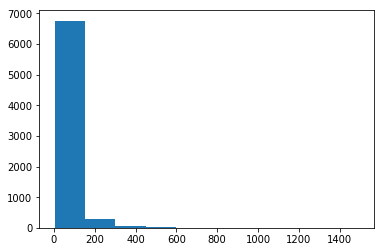

,num_reviews
count,7148.000000
mean,42.495383
std,73.356545
min,3.000000
10%,4.000000
15%,5.000000
20%,6.000000
25%,7.000000
50%,18.000000
60%,26.000000


CPU times: user 571 ms, sys: 16.8 ms, total: 587 ms
Wall time: 667 ms


In [299]:
%%time

# get distribution of num_reviews for businesses
query = """
        MATCH (b:Business)
        RETURN b.name as name, b.num_reviews as num_reviews
        ORDER BY num_reviews DESCENDING
        """

with driver.session() as session:
    business_reviews = session.run(query)

business_reviews_df = pd.DataFrame([dict(record) for record in business_reviews])
display(business_reviews_df.head(10))

plt.hist(business_reviews_df['num_reviews'])
plt.show()     
display(business_reviews_df.describe(percentiles=[0.1,0.15,0.2,0.25,0.5,0.6,0.75,0.8,0.9]))

In [301]:
# set cut off for businesses to be 25 reviews.  check number of business nodes we will have left
business_reviews_df[business_reviews_df.num_reviews >= 25].shape

(2976, 2)

In [302]:
%%time

# delete businesses with less than 25 reviews
query = """
        MATCH (b:Business)
        WHERE b.num_reviews < 25
        DELETE b
        """

with driver.session() as session:
    result = session.run(query)

CPU times: user 1.71 ms, sys: 2.06 ms, total: 3.77 ms
Wall time: 278 ms


In [305]:
%%time

# confirm that we have 2976 business nodes left
query = """
        MATCH (b:Business)
        RETURN COUNT(b) as num_business
        """

with driver.session() as session:
    business_nodes_remaining = session.run(query)
    
business_nodes_remaining_df = pd.DataFrame([dict(record) for record in business_nodes_remaining])
display(business_nodes_remaining_df)

,num_business
0,2976


CPU times: user 5.43 ms, sys: 1.25 ms, total: 6.68 ms
Wall time: 41.9 ms


### Part 5: Load category data, only for businesses already in the graph. 

In [306]:
%%time

load_category = """
    LOAD CSV WITH HEADERS FROM {input_dir} AS line                      
    WITH line 

    // Only load categories associated with businesses that are already in the graph.
    MATCH (business:Business {id: line.business_id})
   
    // Create Category nodes
    WITH line, business, split(line.categories, ";") as cat_list
    UNWIND cat_list as cat
    MERGE (category:Category {name: cat})
    CREATE (business)-[:IN_CATEGORY]->(category)
    """

with driver.session() as session:
    session.run(load_category, input_dir='file:///business.csv')
    

CPU times: user 1.65 ms, sys: 2.6 ms, total: 4.24 ms
Wall time: 968 ms


In [307]:
%%time
# count number of categories in the graph

query = """
        MATCH (c:Category)
        RETURN COUNT(c) as num_category
        """

with driver.session() as session:
    category_count = session.run(query)
    
category_count_df = pd.DataFrame([dict(record) for record in category_count])
display(category_count_df)

,num_category
0,252


CPU times: user 6.18 ms, sys: 2.22 ms, total: 8.4 ms
Wall time: 90 ms


,name,num_business_in_cat
3,Restaurants,2976
6,Food,594
1,Nightlife,549
4,Bars,538
44,Canadian (New),353
33,Breakfast & Brunch,308
15,Japanese,298
48,Italian,265
22,Sandwiches,208
12,Chinese,196


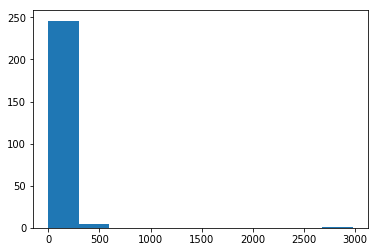

,num_business_in_cat
count,252.000000
mean,47.742063
std,201.653249
min,1.000000
10%,1.000000
15%,1.000000
20%,1.000000
25%,1.000000
50%,6.000000
60%,10.000000


CPU times: user 286 ms, sys: 12.7 ms, total: 298 ms
Wall time: 327 ms


In [316]:
%%time

# count number of businesses in a category
query = """
        MATCH (c:Category)
        RETURN c.name as name, size(()-[:IN_CATEGORY]->(c)) AS num_business_in_cat   
        ORDER BY c, num_business_in_cat DESC
        """

with driver.session() as session:
    business_in_category_count = session.run(query)

business_in_category_count_df = pd.DataFrame([dict(record) for record in business_in_category_count])
display(business_in_category_count_df.sort_values('num_business_in_cat', ascending=False).head(10))

plt.hist(business_in_category_count_df['num_business_in_cat'])
plt.show()     
display(business_in_category_count_df.describe(percentiles=[0.1,0.15,0.2,0.25,0.5,0.6,0.75,0.8,0.9]))


In [317]:
# set cut off for categories to be 10 businesses.  check number of category nodes we will have left
business_in_category_count_df[business_in_category_count_df.num_business_in_cat >= 10].shape

(105, 2)

In [335]:
# get a list of categories with less than 10 businesses
categories_to_delete = business_in_category_count_df[business_in_category_count_df.num_business_in_cat <  10]['name'].tolist()
len(categories_to_delete)

147

In [336]:
# other categories to delete
other_categories_to_delete = ['Restaurants','Food','Grocery','Event Planning & Services','Venues & Event Spaces','Caterers','Food Delivery Services','Shopping','Arts & Entertainment','Music Venues','Lounges','Food Service Delivery']
len(other_categories_to_delete)

12

In [337]:
# combine categories to delete
all_categories_to_delete = categories_to_delete + other_categories_to_delete
len(all_categories_to_delete)

159

In [340]:
%%time

# look at number of relationships that must be first removed, before removing the categories above
query = """
        MATCH (c:Category)<-[r:IN_CATEGORY]-()
        WHERE c.name in {category_list}
        RETURN COUNT(r)
        """

with driver.session() as session:
    cat_to_delete = session.run(query, category_list = all_categories_to_delete)


cat_to_delete_df = pd.DataFrame([dict(record) for record in cat_to_delete])
    
display(cat_to_delete_df)

,COUNT(r)
0,4308


CPU times: user 7.84 ms, sys: 2.54 ms, total: 10.4 ms
Wall time: 94.8 ms


In [341]:
%%time

# delete relationships
query = """
        MATCH (c:Category)<-[r:IN_CATEGORY]-()
        WHERE c.name in {category_list}
        DELETE r
        """

with driver.session() as session:
    result = session.run(query, category_list = all_categories_to_delete)

CPU times: user 3.09 ms, sys: 1.59 ms, total: 4.69 ms
Wall time: 142 ms


In [342]:
%%time

# now remove nodes corresponding to categories to be deleted
query = """
        MATCH (c:Category)
        WHERE c.name in {category_list}
        DELETE c
        """

with driver.session() as session:
    result = session.run(query, category_list = all_categories_to_delete)

CPU times: user 2.85 ms, sys: 2.7 ms, total: 5.55 ms
Wall time: 77.5 ms


In [343]:
%%time

# check number of categories we have remaining
query = """
        MATCH (c:Category)
        RETURN COUNT(c) as num_categories
        """

with driver.session() as session:
    category_nodes_remaining = session.run(query)
    
category_nodes_remaining_df = pd.DataFrame([dict(record) for record in category_nodes_remaining])
display(category_nodes_remaining_df)

,num_categories
0,94


CPU times: user 8.89 ms, sys: 2.71 ms, total: 11.6 ms
Wall time: 223 ms


In [352]:
%%time

# with the removal of category nodes, there may be some businesses not belonging to a category
query = """
        MATCH (b:Business)
        WHERE NOT (b)-[:IN_CATEGORY]->()
        RETURN b.name as business
        """

with driver.session() as session:
    orphan_business = session.run(query)
    
orphan_business_df = pd.DataFrame([dict(record) for record in orphan_business])
display(orphan_business_df)

,business
0,Olly Fresco's
1,Das Gasthaus
2,Budapest Restaurant
3,CASA manila
4,Platito Filipino Soul Food
5,Satay Sate
6,Lamesa Filipino Kitchen
7,Julie's Cuban Restaurant
8,Bamiyan Kabob
9,Otto's Bierhalle


CPU times: user 8.04 ms, sys: 2.4 ms, total: 10.4 ms
Wall time: 40.2 ms


In [358]:
# get a list of categories with less than 10 businesses
orphan_businesses_to_delete = orphan_business_df['business'].tolist()
len(orphan_businesses_to_delete)

13

In [361]:
%%time

# remove these orphan business nodes

query = """
        MATCH (b:Business)
        WHERE b.name in {business_list}
        DELETE b
        """

with driver.session() as session:
    delete_orphan_businesses = session.run(query, business_list = orphan_businesses_to_delete)

CPU times: user 1.92 ms, sys: 2.31 ms, total: 4.23 ms
Wall time: 66.7 ms


In [362]:
%%time

# check number of business nodes we have remaining
query = """
        MATCH (b:Business)
        RETURN COUNT(b)
        """

with driver.session() as session:
    business_nodes_remaining = session.run(query)
    
business_nodes_remaining_df = pd.DataFrame([dict(record) for record in business_nodes_remaining])
display(business_nodes_remaining_df.head())


,COUNT(b)
0,2963


CPU times: user 6.26 ms, sys: 2.37 ms, total: 8.63 ms
Wall time: 33.2 ms


### Part 6.  Load review.csv, but only reviews for businesses already in the graph.

In [379]:
%%time

load_review = """
    // Load and commit every 50000 records
    USING PERIODIC COMMIT 50000 
    LOAD CSV WITH HEADERS FROM {input_dir} AS line                      
    WITH line 

    // Only care about businesses that are already in the graph
    MATCH (business:Business {id:line.business_id})
    MERGE (user:User         {id:line.user_id})
    
    CREATE (user)-[:REVIEWED  {stars:toInteger(line.stars)}]->(business)
    """

with driver.session() as session:
    session.run(load_review, input_dir='file:///review.csv')

CPU times: user 3.87 ms, sys: 3.43 ms, total: 7.3 ms
Wall time: 1min


In [383]:
%%time
# get number of businesses reviewed by user

query = """
        MATCH (u:User)
        RETURN u.id as id, size((u)-[:REVIEWED]->()) AS num_business_reviewed   
        ORDER BY id, num_business_reviewed DESC
        """

with driver.session() as session:
    user_review_count = session.run(query)


user_review_count_df = pd.DataFrame([dict(record) for record in user_review_count])
    
display(user_review_count_df.head(10))

,id,num_business_reviewed
0,--7gjElmOrthETJ8XqzMBw,1
1,--Br-QsbO9ad5GbZxVGxaw,1
2,--BumyUHiO_7YsHurb9Hkw,29
3,--DKDJlRHfsvufdGSk_Sdw,1
4,--EVSb3jbKVL3WJ5NUCuCA,1
5,--KQJPdrU0Md97DiOliDzw,1
6,--Qh8yKWAvIP4V4K8ZPfHA,170
7,--RYvmB6UYRyZQqXkBv4eQ,1
8,--UOvCH5qEgdNQ8lzR8QYQ,7
9,--WhK4MJx0fKvg64LqwStg,1


CPU times: user 2.38 s, sys: 33.9 ms, total: 2.42 s
Wall time: 2.64 s


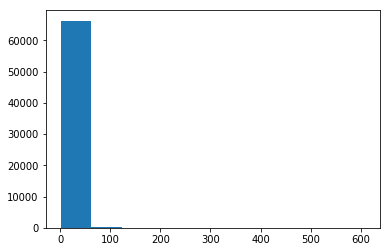

,num_business_reviewed
count,66639.000000
mean,3.921457
std,10.314604
min,1.000000
10%,1.000000
15%,1.000000
20%,1.000000
25%,1.000000
50%,1.000000
60%,2.000000


In [386]:
plt.hist(user_review_count_df['num_business_reviewed'])
plt.show()     
display(user_review_count_df.describe(percentiles=[0.1,0.15,0.2,0.25,0.5,0.6,0.75,0.8,0.9,0.95,0.99]))


In [387]:
user_review_count_df[user_review_count_df['num_business_reviewed'] >= 5].shape

(11293, 2)

In [ ]:
# for now, don't remove users.  run LPA on users with at least 5 reviews